# Idea

Take two sequences with a very high sequence similarity and mutate X into Y and Y into X. Consider the average mutational effect over the entire sequence. Is it the same or is one worde than the other? 

In [7]:
import pandas as pd
import sys 
sys.path.append('../vespag')

from parse.vep_scores import load_vespag_scores_from_folder, load_dms_scores_from_folder, load_fasta_file
from tqdm import tqdm

In [39]:
# load the PLA2 dataset 
pla2_fasta_file = '../data/20231031_PLA2.fasta'

pla2_sequences = load_fasta_file(pla2_fasta_file)
pla2_sequences['sequence'] = pla2_sequences['sequence'].astype(str)
pla2_sequences.head()

,id,sequence
0,P00622_caudoxin_Bitis_caudalis,NLIQFGNMISAMTGKSSLAYASYGCYCGWGGKGQPKDDTDRCCFVH...
1,DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...


In [71]:
pla2_sequences['length'] = pla2_sequences['sequence'].apply(len)
c_atrox_length = pla2_sequences[pla2_sequences['id'] == 'MF974418_1_Crotalus_atrox']['length'].values[0]
c_atrox_sequence = pla2_sequences[pla2_sequences['id'] == 'MF974418_1_Crotalus_atrox']['sequence'].values[0]
df = pla2_sequences[(pla2_sequences.length == c_atrox_length) & (pla2_sequences['id'] != 'MF974418_1_Crotalus_atrox')].copy()
df['n_different'] = df.apply(lambda x: sum([1 for i in range(len(x['sequence'])) if x['sequence'][i] != c_atrox_sequence[i]]), axis=1)
df['differing_residues'] = df.apply(lambda x: [i+1 for i in range(len(x['sequence'])) if x['sequence'][i] != c_atrox_sequence[i]], axis=1)
df = df.sort_values('n_different')
df.head()

,id,sequence,length,n_different,differing_residues
507,sCratGa,SLLQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[3]
380,MF974433_1_Crotalus_scutulatus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[104]
382,KU666919_1_Crotalus_cerberus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,2,"[104, 120]"
387,JF895774_1_Crotalus_helleri,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,4,"[12, 14, 35, 74]"
385,MK393898_1_Crotalus_adamanteus,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,5,"[12, 14, 35, 74, 112]"


In [73]:
# build the mutations from c atrox to other sequences
def build_mutation(row):
    residues = row['differing_residues']
    mutations = []
    inverted_mutation = []
    for r in residues:
        mutations.append(f'{c_atrox_sequence[r-1]}{r}{row["sequence"][r-1]}')
        inverted_mutation.append(f'{row["sequence"][r-1]}{r}{c_atrox_sequence[r-1]}')
    return mutations, inverted_mutation

df['mutations'], df['inverted_mutations'] = zip(*df.apply(build_mutation, axis=1))
df.head()

,id,sequence,length,n_different,differing_residues,mutations,inverted_mutations
507,sCratGa,SLLQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[3],[V3L],[L3V]
380,MF974433_1_Crotalus_scutulatus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[104],[D104S],[S104D]
382,KU666919_1_Crotalus_cerberus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,2,"[104, 120]","[D104N, E120K]","[N104D, K120E]"
387,JF895774_1_Crotalus_helleri,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,4,"[12, 14, 35, 74]","[I12V, G14K, L35R, I74V]","[V12I, K14G, R35L, V74I]"
385,MK393898_1_Crotalus_adamanteus,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,5,"[12, 14, 35, 74, 112]","[I12V, G14K, L35R, I74V, P112S]","[V12I, K14G, R35L, V74I, S112P]"


In [74]:
vespag_results = load_vespag_scores_from_folder('/mnt/f/nicole/pla2_vespag/')
vespag_results['vespag'] = -vespag_results['vespag']
vespag_results['mutation_effect'] = (vespag_results['vespag'] - vespag_results['vespag'].min()) / (vespag_results['vespag'].max() - vespag_results['vespag'].min())
vespag_results.head()

Loading VespaG scores: 100%|██████████| 524/524 [00:05<00:00, 97.30file/s] 


,residue,mutation,vespag,id,mutation_effect
0,N1,N1A,2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.364656
1,N1,N1Y,3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.493063
2,N1,N1W,4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.530656
3,N1,N1V,3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.471612
4,N1,N1T,2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.343762


In [81]:
# calculate the mean effect of the mutations to go from c atrox to other sequences and the other way around 
def get_mutation_effects(row, vespag_scores):
    mutations = row['mutations']
    inverted_mutations = row['inverted_mutations']

    # find the mutations for the correct sequence
    mutation_effects = list(vespag_scores[(vespag_scores['mutation'].isin(mutations)) & (vespag_scores['id'] == 'MF974418_1_Crotalus_atrox')].mutation_effect.round(4))
    inverted_mutation_effects = list(vespag_scores[(vespag_scores['mutation'].isin(inverted_mutations)) & (vespag_scores['id'] == row['id'])].mutation_effect.round(4))

    return mutation_effects, inverted_mutation_effects

df['mutation_effects'], df['inverted_mutation_effects'] = zip(*df.apply(lambda x: get_mutation_effects(x, vespag_results), axis=1))
df.head()

,id,sequence,length,n_different,differing_residues,mutations,inverted_mutations,mutation_effects,inverted_mutation_effects,mean_mutation_effect,mean_inverted_mutation_effect
507,sCratGa,SLLQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[3],[V3L],[L3V],[0.1841],[0.2027],0.184071,0.202737
380,MF974433_1_Crotalus_scutulatus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[104],[D104S],[S104D],[0.3074],[0.2396],0.307396,0.239567
382,KU666919_1_Crotalus_cerberus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,2,"[104, 120]","[D104N, E120K]","[N104D, K120E]","[0.1905, 0.2496]","[0.2323, 0.1691]",0.220088,0.200683
387,JF895774_1_Crotalus_helleri,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,4,"[12, 14, 35, 74]","[I12V, G14K, L35R, I74V]","[V12I, K14G, R35L, V74I]","[0.1197, 0.3834, 0.1984, 0.1756]","[0.1771, 0.1884, 0.2021, 0.1953]",0.219259,0.190749
385,MK393898_1_Crotalus_adamanteus,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,5,"[12, 14, 35, 74, 112]","[I12V, G14K, L35R, I74V, P112S]","[V12I, K14G, R35L, V74I, S112P]","[0.1197, 0.3834, 0.1984, 0.1756, 0.1738]","[0.1755, 0.1889, 0.2021, 0.1937, 0.3421]",0.210162,0.220446


In [82]:
df['mean_mutation_effect'] = df['mutation_effects'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
df['mean_inverted_mutation_effect'] = df['inverted_mutation_effects'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
df.head()

,id,sequence,length,n_different,differing_residues,mutations,inverted_mutations,mutation_effects,inverted_mutation_effects,mean_mutation_effect,mean_inverted_mutation_effect
507,sCratGa,SLLQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[3],[V3L],[L3V],[0.1841],[0.2027],0.184100,0.202700
380,MF974433_1_Crotalus_scutulatus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[104],[D104S],[S104D],[0.3074],[0.2396],0.307400,0.239600
382,KU666919_1_Crotalus_cerberus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,2,"[104, 120]","[D104N, E120K]","[N104D, K120E]","[0.1905, 0.2496]","[0.2323, 0.1691]",0.220050,0.200700
387,JF895774_1_Crotalus_helleri,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,4,"[12, 14, 35, 74]","[I12V, G14K, L35R, I74V]","[V12I, K14G, R35L, V74I]","[0.1197, 0.3834, 0.1984, 0.1756]","[0.1771, 0.1884, 0.2021, 0.1953]",0.219275,0.190725
385,MK393898_1_Crotalus_adamanteus,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,5,"[12, 14, 35, 74, 112]","[I12V, G14K, L35R, I74V, P112S]","[V12I, K14G, R35L, V74I, S112P]","[0.1197, 0.3834, 0.1984, 0.1756, 0.1738]","[0.1755, 0.1889, 0.2021, 0.1937, 0.3421]",0.210180,0.220460


In [87]:
df[df.n_different <= 12]

,id,sequence,length,n_different,differing_residues,mutations,inverted_mutations,mutation_effects,inverted_mutation_effects,mean_mutation_effect,mean_inverted_mutation_effect
507,sCratGa,SLLQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[3],[V3L],[L3V],[0.1841],[0.2027],0.184100,0.202700
380,MF974433_1_Crotalus_scutulatus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,1,[104],[D104S],[S104D],[0.3074],[0.2396],0.307400,0.239600
382,KU666919_1_Crotalus_cerberus,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,2,"[104, 120]","[D104N, E120K]","[N104D, K120E]","[0.1905, 0.2496]","[0.2323, 0.1691]",0.220050,0.200700
387,JF895774_1_Crotalus_helleri,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,4,"[12, 14, 35, 74]","[I12V, G14K, L35R, I74V]","[V12I, K14G, R35L, V74I]","[0.1197, 0.3834, 0.1984, 0.1756]","[0.1771, 0.1884, 0.2021, 0.1953]",0.219275,0.190725
385,MK393898_1_Crotalus_adamanteus,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,5,"[12, 14, 35, 74, 112]","[I12V, G14K, L35R, I74V, P112S]","[V12I, K14G, R35L, V74I, S112P]","[0.1197, 0.3834, 0.1984, 0.1756, 0.1738]","[0.1755, 0.1889, 0.2021, 0.1937, 0.3421]",0.210180,0.220460
386,MF974417_1_Crotalus_adamanteus,SLVQFETLIMKVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,5,"[12, 14, 35, 56, 74]","[I12V, G14K, L35R, D56N, I74V]","[V12I, K14G, R35L, N56D, V74I]","[0.1197, 0.3834, 0.1984, 0.1884, 0.1756]","[0.1756, 0.1886, 0.2063, 0.1836, 0.1982]",0.213100,0.190460
379,AF403134_1_Crotalus_viridis,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,6,"[74, 79, 104, 111, 117, 118]","[I74V, D79N, D104S, P111L, E117G, E118D]","[V74I, N79D, S104D, L111P, G117E, D118E]","[0.1756, 0.2089, 0.3074, 0.2677, 0.2658, 0.1505]","[0.1959, 0.2081, 0.2256, 0.2412, 0.2104, 0.1326]",0.229317,0.202300
383,GQ168368_1_Crotalus_horridus,SLVQFEMMIMEVAKRSGLLWYSAYGCYCGWGGHGRPQDATDRCCFV...,122,8,"[7, 8, 11, 12, 14, 35, 61, 74]","[T7M, L8M, K11E, I12V, G14K, L35R, T61R, I74V]","[M7T, M8L, E11K, V12I, K14G, R35L, R61T, V74I]","[0.2622, 0.2501, 0.2166, 0.1197, 0.3834, 0.198...","[0.2119, 0.2861, 0.1901, 0.1794, 0.1869, 0.208...",0.236200,0.211925
389,KU666918_1_Crotalus_concolor,SLVEFETLIMKIAGRSGFLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,8,"[4, 18, 70, 74, 79, 104, 111, 116]","[Q4E, L18F, N70K, I74V, D79N, D104S, P111L, R1...","[E4Q, F18L, K70N, V74I, N79D, S104D, L111P, Q1...","[0.2477, 0.1706, 0.2937, 0.1756, 0.2089, 0.307...","[0.2709, 0.0903, 0.1924, 0.1961, 0.2061, 0.226...",0.233563,0.205787
378,KX211995_1_Crotalus_atrox,SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFV...,122,8,"[54, 70, 74, 76, 105, 111, 116, 118]","[A54V, N70K, I74V, G76E, N105D, P111L, R116Q, ...","[V54A, K70N, V74I, E76G, D105N, L111P, Q116R, ...","[0.2353, 0.2937, 0.1756, 0.2378, 0.1645, 0.267...","[0.4313, 0.1946, 0.1872, 0.295, 0.1545, 0.2238...",0.223963,0.233113


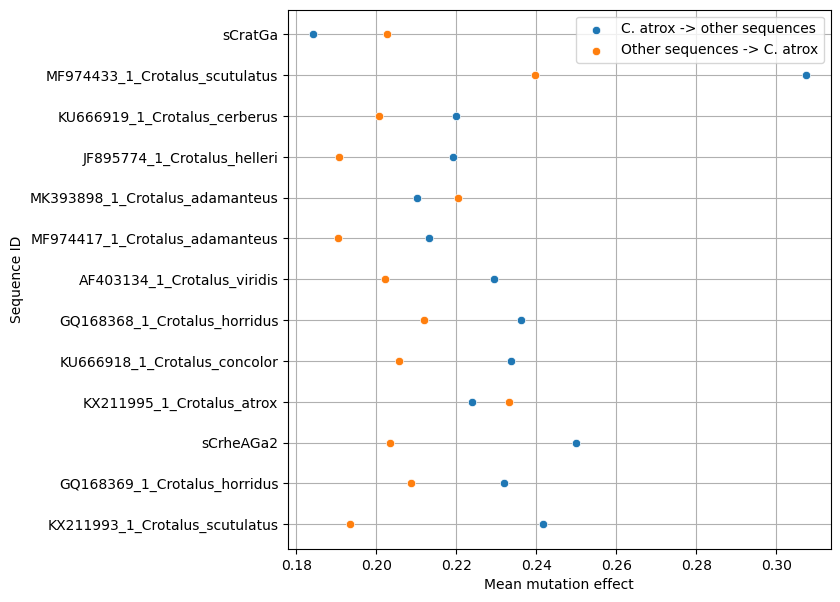

In [101]:
# scatterplot of these mean effects
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.scatterplot(y='id', x='mean_mutation_effect', data=df[df.n_different <= 12], label='C. atrox -> other sequences', zorder=2)
sns.scatterplot(y='id', x='mean_inverted_mutation_effect', data=df[df.n_different <= 12], label='Other sequences -> C. atrox', zorder=2)
plt.xlabel('Mean mutation effect')
plt.ylabel('Sequence ID')
plt.legend()
plt.grid(zorder=0)
plt.show()

## Going from C atrox to MF974433_1_Crotalus_scutulatus only requires one step

In [63]:
# going from c atrox to MF974433_1_Crotalus_scutulatus
residue = 104
wildtype = c_atrox_sequence[residue-1]
mutant = pla2_sequences[pla2_sequences['id'] == 'MF974433_1_Crotalus_scutulatus'].sequence.values[0][residue-1]
mutation = f'{wildtype}{residue}{mutant}'
print(mutation)
vespag_results[(vespag_results['mutation'] == mutation) & (vespag_results['id'] == 'MF974418_1_Crotalus_atrox')]

D104S


,residue,mutation,vespag,id,mutation_effect
992355,D104,D104S,2.051548,MF974418_1_Crotalus_atrox,0.307396


In [64]:
inverted_mutation = f'{mutant}{residue}{wildtype}'
print(inverted_mutation)
vespag_results[(vespag_results['mutation'] == inverted_mutation) & (vespag_results['id'] == 'MF974433_1_Crotalus_scutulatus')]

S104D


,residue,mutation,vespag,id,mutation_effect
402321,S104,S104D,1.458209,MF974433_1_Crotalus_scutulatus,0.239567
